adapt from https://github.com/LSSTDESC/transient-host-sims/blob/main/notebooks/SCOTCH_walkthroughs.ipynb
and https://github.com/LSSTDESC/transient-host-sims/blob/main/notebooks/pzflow_DC2_conditionalFlow_finalCut.ipynb
and https://jfcrenshaw.github.io/pzflow/tutorials/intro/

In [1]:
# import jax
# jax.default_backend()
# import os
# os.environ["JAX_PLATFORM_NAME"] = "cpu"

In [2]:
import pandas as pd
import numpy as np
import pzflow
from pzflow import Flow
from pzflow.bijectors import Chain, ColorTransform, InvSoftplus, StandardScaler, RollingSplineCoupling
# from pzflow.examples import galaxy_data
from pzflow.distributions import Uniform, Joint, Normal
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.stats.sampling import NumericalInversePolynomial

In [3]:
globalhostdata = pd.read_csv('ztfsniadr2/tables/globalhost_data.csv')
localhostdata = pd.read_csv('ztfsniadr2/tables/localhost_data.csv')
sndata = pd.read_csv('ztfsniadr2/tables/snia_data.csv')

In [4]:
globalhostdata.head()

,ztfname,ra_host,dec_host,mass,mass_err,restframe_gz,restframe_gz_err,d_dlr
0,ZTF17aadlxmv,127.448161,33.906468,10.424,0.116619,1.061697,0.018439,0.083759
1,ZTF18aaadqua,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ZTF18aaanzph,157.746954,23.788548,10.996,0.123223,1.351697,0.018439,1.698443
3,ZTF18aaapivw,102.564481,27.141323,8.515,0.103325,0.591697,0.046861,2.969719
4,ZTF18aaaqexr,175.776562,15.566957,10.774,0.117661,1.211697,0.018439,0.102694


In [5]:
localhostdata.head()

,ztfname,mass,mass_err,restframe_gz,restframe_gz_err
0,ZTF17aadlxmv,10.001,0.025,1.218697,0.017029
1,ZTF18aaadqua,6.743,0.344,0.321697,1.289935
2,ZTF18aaanzph,8.344,0.168,1.287697,0.500016
3,ZTF18aaapivw,7.507,0.092,0.607697,0.336146
4,ZTF18aaaqexr,10.727,0.065,1.313697,0.017692


In [6]:
sndata.head()

,Unnamed: 0,ztfname,redshift,redshift_err,source,t0,x0,x1,c,t0_err,...,mwebv_err,fitprob,ra,dec,sn_type,sub_type,lccoverage_flag,fitquality_flag,iau_name,frac_fitted
0,0,ZTF17aadlxmv,0.062019,0.000013,z_gal,58878.085277,0.001126,0.459966,0.062074,0.219280,...,0.0,0.178353,127.448018,33.906536,snia-cosmo,norm,1.0,1.0,2020adv,100.0
1,1,ZTF18aaadqua,0.078672,0.002807,z_snid,58130.778798,0.000845,4.999999,-0.392734,14.743977,...,0.0,0.127972,26.798708,18.798611,snia-pec,03fg,0.0,0.0,2018lq,100.0
2,2,ZTF18aaanzph,0.063718,0.000016,z_gal,58138.014461,0.000275,-1.224903,0.567260,8.873835,...,0.0,0.576895,157.743465,23.788356,snia-cosmo,norm,0.0,0.0,2018kc,100.0
3,3,ZTF18aaapivw,0.026341,0.004328,z_snid,58152.873526,0.001008,-4.999998,0.660968,0.971755,...,0.0,0.249074,102.563278,27.140073,snia-cosmo,norm,0.0,0.0,2018xi,100.0
4,4,ZTF18aaaqexr,0.070258,0.000022,z_gal,58893.687923,0.000610,-1.437246,0.048229,0.170907,...,0.0,0.038322,175.776516,15.567129,snia,NaN,1.0,1.0,2020chl,100.0


In [7]:
data = pd.merge(sndata,globalhostdata,on='ztfname')
data.head()

,Unnamed: 0,ztfname,redshift,redshift_err,source,t0,x0,x1,c,t0_err,...,fitquality_flag,iau_name,frac_fitted,ra_host,dec_host,mass,mass_err,restframe_gz,restframe_gz_err,d_dlr
0,0,ZTF17aadlxmv,0.062019,0.000013,z_gal,58878.085277,0.001126,0.459966,0.062074,0.219280,...,1.0,2020adv,100.0,127.448161,33.906468,10.424,0.116619,1.061697,0.018439,0.083759
1,1,ZTF18aaadqua,0.078672,0.002807,z_snid,58130.778798,0.000845,4.999999,-0.392734,14.743977,...,0.0,2018lq,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,ZTF18aaanzph,0.063718,0.000016,z_gal,58138.014461,0.000275,-1.224903,0.567260,8.873835,...,0.0,2018kc,100.0,157.746954,23.788548,10.996,0.123223,1.351697,0.018439,1.698443
3,3,ZTF18aaapivw,0.026341,0.004328,z_snid,58152.873526,0.001008,-4.999998,0.660968,0.971755,...,0.0,2018xi,100.0,102.564481,27.141323,8.515,0.103325,0.591697,0.046861,2.969719
4,4,ZTF18aaaqexr,0.070258,0.000022,z_gal,58893.687923,0.000610,-1.437246,0.048229,0.170907,...,1.0,2020chl,100.0,175.776562,15.566957,10.774,0.117661,1.211697,0.018439,0.102694


In [8]:
data.columns

Index(['Unnamed: 0', 'ztfname', 'redshift', 'redshift_err', 'source', 't0',
       'x0', 'x1', 'c', 't0_err', 'x0_err', 'x1_err', 'c_err', 'cov_t0_x0',
       'cov_t0_x1', 'cov_t0_c', 'cov_x0_x1', 'cov_x0_c', 'cov_x1_c', 'mwebv',
       'mwr_v', 'mwebv_err', 'fitprob', 'ra', 'dec', 'sn_type', 'sub_type',
       'lccoverage_flag', 'fitquality_flag', 'iau_name', 'frac_fitted',
       'ra_host', 'dec_host', 'mass', 'mass_err', 'restframe_gz',
       'restframe_gz_err', 'd_dlr'],
      dtype='object')

In [9]:
data_train = data[['mass','x1','c']]
data_train

,mass,x1,c
0,10.424,0.459966,0.062074
1,NaN,4.999999,-0.392734
2,10.996,-1.224903,0.567260
3,8.515,-4.999998,0.660968
4,10.774,-1.437246,0.048229
...,...,...,...
3623,10.620,-0.820927,-0.125119
3624,9.818,0.985630,0.088372
3625,10.378,5.000000,-0.352244
3626,10.728,-0.264331,0.199896


In [10]:
data_train = data_train.dropna()
data_train

,mass,x1,c
0,10.424,0.459966,0.062074
2,10.996,-1.224903,0.567260
3,8.515,-4.999998,0.660968
4,10.774,-1.437246,0.048229
6,9.870,4.999980,1.008026
...,...,...,...
3623,10.620,-0.820927,-0.125119
3624,9.818,0.985630,0.088372
3625,10.378,5.000000,-0.352244
3626,10.728,-0.264331,0.199896


In [11]:
flow = Flow(data_train.columns)

In [12]:
losses = flow.train(data_train, verbose=True)

Training 100 epochs 
Loss:
(0) 5.4856
(1) 4.8619
(6) 3.2136
(11) 2.8548
(16) 2.5374
(21) 2.4045
(26) 2.2826
(31) 2.2328
(36) 2.1949
(41) 2.1872
(46) 2.1887
(51) 2.1483
(56) 2.1459
(61) 2.1351
(66) 2.1122
(71) 2.1087
(76) 2.0975
(81) 2.0899
(86) 2.0901
(91) 2.0714
(96) 2.1086
(100) 2.0697


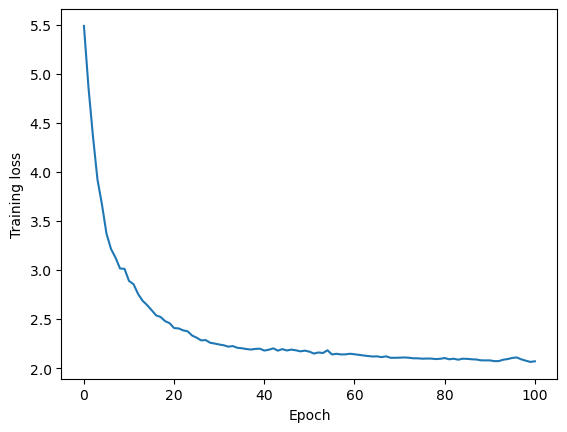

In [13]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Training loss")
plt.show()

In [14]:
flow.save("data/ztfsniadr2_host_sn_pzflow.pkl")

In [15]:
flow = Flow(file="data/ztfsniadr2_host_sn_pzflow.pkl")

In [16]:
samples = flow.sample(100000)

<Axes: >

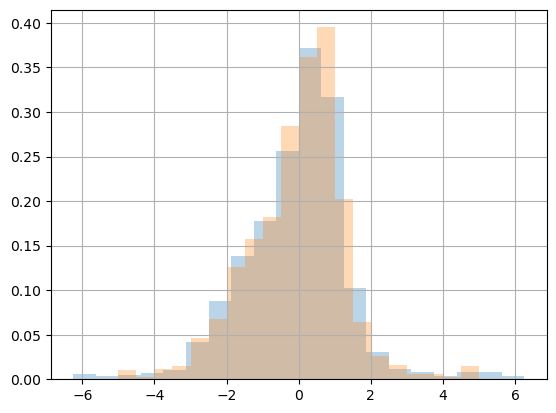

In [17]:
samples.x1.hist(bins=20,alpha=0.3,density=True)
data_train.x1.hist(bins=20,alpha=0.3,density=True)

<Axes: >

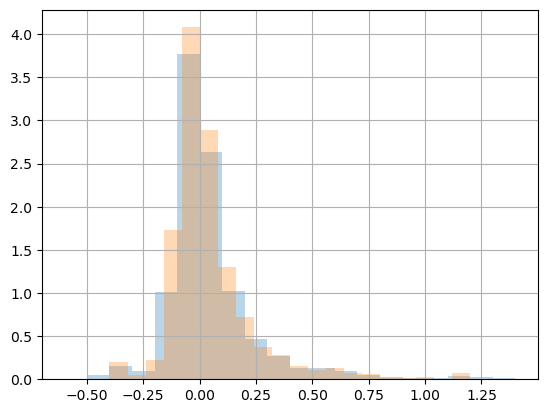

In [18]:
samples.c.hist(bins=20,alpha=0.3,density=True)
data_train.c.hist(bins=20,alpha=0.3,density=True)

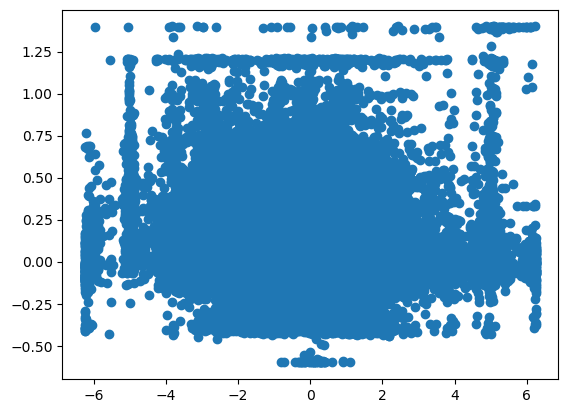

In [19]:
plt.scatter(samples['x1'],samples['c'])

In [20]:
cov = np.cov(samples['x1'],samples['c'])

In [21]:
cov

array([[ 2.13104699, -0.01535161],
       [-0.01535161,  0.04137018]])

In [22]:
fx1_arr = np.loadtxt('data/ztf_selection_func_x1.txt')
fc_arr = np.loadtxt('data/ztf_selection_func_c.txt')

In [23]:
binwidth_x1 = fx1_arr[0][1]-fx1_arr[0][0]
binwidth_c = fc_arr[0][1]-fc_arr[0][0]

bins_x1 = np.append((fx1_arr[0]-0.5*binwidth_x1), fx1_arr[0][-1]+0.5*binwidth_x1)
bins_c = np.append((fc_arr[0]-0.5*binwidth_c), fc_arr[0][-1]+0.5*binwidth_c)

x1_binned_pdf,x1_bin_edges = np.histogram(samples['x1'],bins=bins_x1)
c_binned_pdf,c_bin_edges = np.histogram(samples['c'],bins=bins_c)

x1_binned_pdf_modified = x1_binned_pdf/fx1_arr[1]
c_binned_pdf_modified = c_binned_pdf/fc_arr[1]

<BarContainer object of 19 artists>

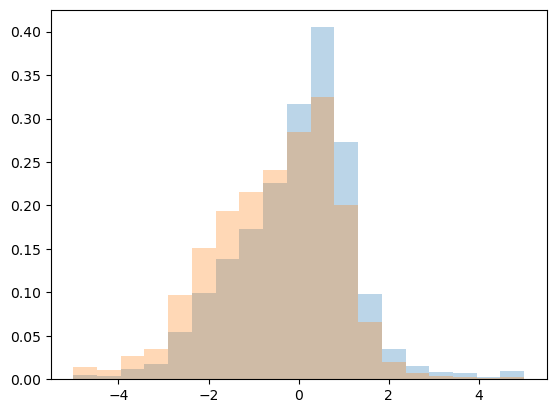

In [24]:
plt.bar(0.5*(x1_bin_edges[:-1]+x1_bin_edges[1:]),x1_binned_pdf/np.sum(x1_binned_pdf)/binwidth_x1,alpha=0.3,width=binwidth_x1)
plt.bar(0.5*(x1_bin_edges[:-1]+x1_bin_edges[1:]),x1_binned_pdf_modified/np.sum(x1_binned_pdf_modified)/binwidth_x1,alpha=0.3,width=binwidth_x1)


<BarContainer object of 19 artists>

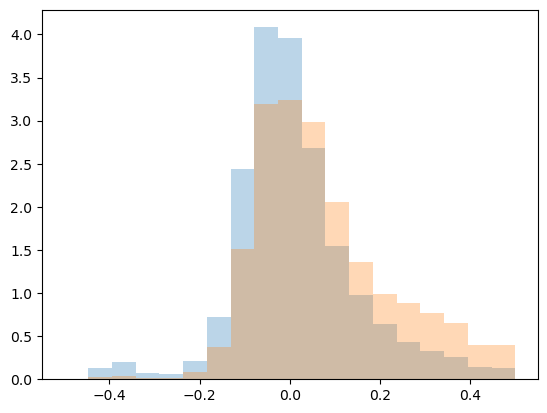

In [25]:
plt.bar(0.5*(c_bin_edges[:-1]+c_bin_edges[1:]),c_binned_pdf/np.sum(c_binned_pdf)/binwidth_c,alpha=0.3,width=binwidth_c)
plt.bar(0.5*(c_bin_edges[:-1]+c_bin_edges[1:]),c_binned_pdf_modified/np.sum(c_binned_pdf_modified)/binwidth_c,alpha=0.3,width=binwidth_c)

In [26]:
x1_pdf = interp1d(fx1_arr[0],x1_binned_pdf_modified,fill_value=[0.],bounds_error=False)
c_pdf = interp1d(fc_arr[0],c_binned_pdf_modified,fill_value=[0.],bounds_error=False)

In [27]:
class x1distr:
   def pdf(self, x):
       return x1_pdf(x)

In [28]:
class cdistr:
   def pdf(self, x):
       return c_pdf(x)

In [29]:
urng = np.random.default_rng()

dist = x1distr()
rng = NumericalInversePolynomial(dist, random_state=urng)
x1 = rng.rvs(100000)

dist = cdistr()
rng = NumericalInversePolynomial(dist, random_state=urng)
c = rng.rvs(100000)

Training 100 epochs 
Loss:
(0) 2.1573
(1) 2.0241
(6) 1.6596
(11) 1.4402
(16) 1.2849
(21) 1.1976
(26) 1.1516
(31) 1.1413
(36) 1.1192
(41) 1.1070
(46) 1.0951
(51) 1.0966
(56) 1.0928
(61) 1.0859
(66) 1.0842
(71) 1.0946
(76) 1.0778
(81) 1.0719
(86) 1.0816
(91) 1.0727
(96) 1.0819
(100) 1.0678


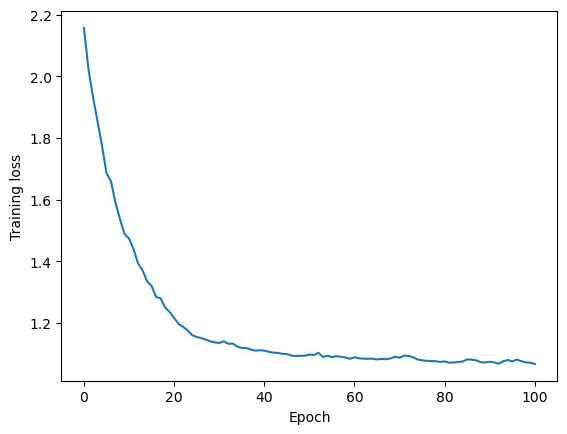

In [30]:
flow_cond = Flow(data_columns=["mass"], conditional_columns=["x1","c"])
losses = flow_cond.train(data_train, verbose=True)
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Training loss")
plt.show()

In [31]:
df = pd.DataFrame({"x1":x1,"c":c})
samples_cond = flow_cond.sample(1, conditions=df)

<Axes: >

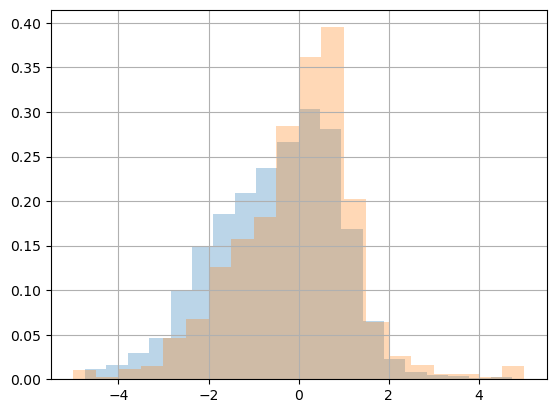

In [32]:
samples_cond.x1.hist(bins=20,alpha=0.3,density=True)
data_train.x1.hist(bins=20,alpha=0.3,density=True)

<Axes: >

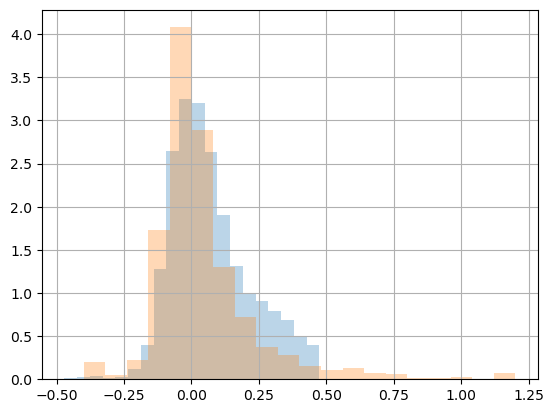

In [33]:
samples_cond.c.hist(bins=20,alpha=0.3,density=True)
data_train.c.hist(bins=20,alpha=0.3,density=True)

Training 100 epochs 
Loss:
(0) 5.1798
(1) 2.3519
(6) 2.1587
(11) 2.1525
(16) 2.1494
(21) 2.1462
(26) 2.1908
(31) 2.1376
(36) 2.1328
(41) 2.1331
(46) 2.1304
(51) 2.1309
(56) 2.1338
(61) 2.1275
(66) 2.1273
(71) 2.1278
(76) 2.1276
(81) 2.1349
(86) 2.1247
(91) 2.1320
(96) 2.1292
(100) 2.1246


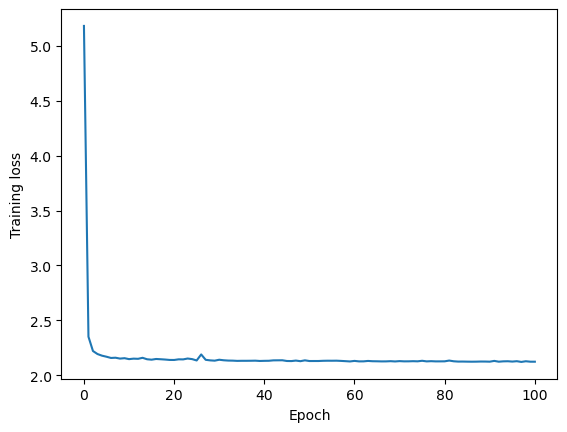

In [34]:
flow_before_selection = Flow(samples_cond.columns)
losses = flow_before_selection.train(samples_cond, verbose=True)
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Training loss")
plt.show()

In [35]:
flow_before_selection.save("data/ztfsniadr2_host_sn_before_selection_pzflow.pkl")

In [36]:
flow = Flow(file="data/ztfsniadr2_host_sn_before_selection_pzflow.pkl")

In [37]:
samples = flow.sample(1000)

<Axes: >

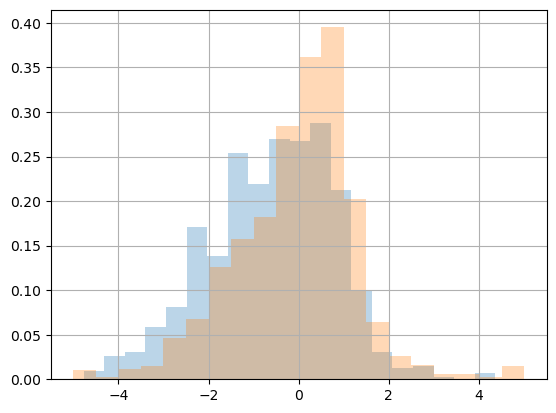

In [38]:
samples.x1.hist(bins=20,alpha=0.3,density=True)
data_train.x1.hist(bins=20,alpha=0.3,density=True)

<Axes: >

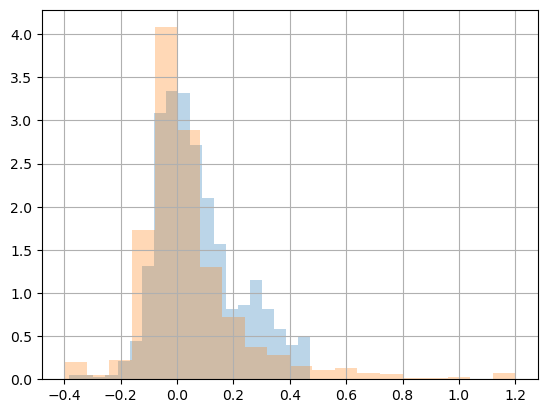

In [39]:
samples.c.hist(bins=20,alpha=0.3,density=True)
data_train.c.hist(bins=20,alpha=0.3,density=True)